# Twitter Analysis

In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark\\spark-3.0.0-preview2-bin-hadoop2.7'

In [2]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import desc

In [3]:
#creating spark, streaming and SQL context
spark_context = SparkContext()
streaming_context = StreamingContext(spark_context, 10)
sqlContext = SQLContext(spark_context)
spark = SparkSession.builder.appName('Sparksql').getOrCreate()

In [4]:
# initiate streaming text from a TCP (socket) source:
tcp_socket_stream = streaming_context.socketTextStream("127.0.0.1", 5555)
# RDDs that contain the tweets with socket_stream window of size 60, or 60 #seconds windows of time
rdds = tcp_socket_stream.window(60)

In [5]:
import string

#creating a function to remove all punctuation from the tweets
def remove_punctuation(text):
    no_punc_text = "".join([t for t in text if t not in string.punctuation])
    return no_punc_text

In [6]:
from collections import namedtuple

fields = ("word", "count")
Tweet = namedtuple( 'Tweet', fields )

(rdds.map(lambda text: remove_punctuation(text)) #this removes punctuation from every tweets before its stored in the RDDs
 .flatMap( lambda text: text.split( " " ) ) #Splits to a list
 .filter(lambda word: word.lower()) 
 .map( lambda word: (word, 1))
  .reduceByKey( lambda a, b: a + b )
  .map( lambda rec: Tweet( rec[0], rec[1]))
  .foreachRDD( lambda rdd: rdd.toDF().sort("count").createOrReplaceTempView("tweets") )) #creating a temp SQL table so that the words in the tweets can be easily accessed later

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

Run 'requestTweets.py' file now.
After starting the Streaming Context, wait 5 minutes so that enough tweets are collected before querying the SQL Context and doing the analysis of the tweets.

In [8]:
#streaming has started and we the tweets are now being saved into the RDDs 
streaming_context.start()

In [9]:
structured_DB = spark.sql( 'Select word, count from tweets' ) #filtering the SQL table by word and count so that we can analyze the results
structured_DB.show()

+------------------+-----+
|              word|count|
+------------------+-----+
|httpstcoaPVeQlV6TX|    1|
|httpstcofCMXjvoLjR|    1|
|    coronavirusThe|    1|
|          Insanity|    1|
|           exposed|    1|
|            trying|    1|
|             stark|    1|
|                PM|    1|
|            racial|    1|
|     WorldBankMENA|    1|
|          MoHFWHow|    1|
|            atte…9|    1|
|           Finally|    1|
|          citizens|    1|
|               Bye|    1|
|infetiousdiseases…|    1|
|               bye|    1|
|                an|    1|
|               Get|    1|
|             again|    1|
+------------------+-----+
only showing top 20 rows



In [10]:
df_tweetsDB = structured_DB.toPandas() #converts filtered SQL table to Pandas DataFrame

In [11]:
list(df_tweetsDB.columns.values) #listing the column names of the Pandas DataFrame so that we know what we working with

['word', 'count']

In [12]:
type(df_tweetsDB) #print the type of the dataframe to make sure its a pandas dataframe

pandas.core.frame.DataFrame

In [13]:
#This function removes all the website links from the tweets/words
def clean_data(df):
    result=[]
    for index, row in df_tweetsDB.iterrows():
        if ("https" not in row.word):
            result.append(str(row.word.lower()))
    return result

In [14]:
#we look at the results of the clean_data function
words = clean_data(df_tweetsDB)
words

['insanity',
 'again',
 'trying',
 'elections',
 'pm',
 'candidatert',
 'worldbankmena',
 'iraqi',
 'citizens',
 'immunology',
 'infetiousdiseases…',
 'an',
 'shuttle',
 'coronavirusthe',
 'exposed',
 'stark',
 'racial',
 'mohfwhow',
 'finally',
 'bye',
 'bye',
 'get',
 'mciu…',
 'chum',
 'bags',
 'endanger',
 'atte…9',
 'save',
 'give',
 'name',
 'zigfracassi',
 'out',
 'arizona',
 'b…rt',
 'community',
 'blmseattle',
 'stopped',
 'approach',
 'why',
 '5gmindcontrol',
 'now',
 'doug',
 'idk',
 'temporarily',
 'solomonyue',
 'selective',
 'satellite',
 'imagery',
 'must',
 'what',
 'beach',
 'infections',
 'rose',
 '308993',
 'recovered',
 'patien…carsharing',
 'during',
 'youre',
 'safe',
 'dabeard',
 'because',
 'west',
 'cadets',
 'two',
 'weeks',
 'yet',
 'physical',
 'layers',
 'cottonbamboo',
 'regulating',
 'unprecedented',
 'nicolas',
 'record',
 'eu',
 'epidemic',
 'peak…',
 'walt',
 'reopen',
 'become',
 'baghdad',
 'acting',
 'concerns',
 'black',
 'matter',
 'damn',
 'mask'

In [15]:
tweets = pd.DataFrame({'word': words}) #creating a Pandas DataFrame that contains only the words

In [16]:
from profanity_check import predict
from spellchecker import SpellChecker
from autocorrect import Speller

#spell = SpellChecker()

spell = Speller(lang='en')

#function to generate the profanity of each tweet
def offensive(df):
    result = []
    for word in df:
        result.append((predict([word])==1)[0])
    return result

#function to generate a list of boolean values that corresponds to whether the tweets are misspelt or not
def misspelt(df):
    result = []
    for word in df:
        if (word[:2])=="RT" or ("@" in word) or ("#" in word) or ("." in word) or ("'" in word): #if a tweets contains any of these then its not misspelt
            result.append(False)
        else:
            result.append(word != spell(word))
    return result

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot 

In [17]:
tweets["offensive"] = offensive(tweets["word"]) #adding a 'offensive' column to our Pandas DataFrame
tweets["misspelt"] = misspelt(tweets["word"]) #adding a 'misspelt' column to our Pandas DataFrame

In [18]:
tweets #visualizing results of previous additions

,word,offensive,misspelt
0,insanity,False,False
1,again,False,False
2,trying,False,False
3,elections,False,False
4,pm,False,False
...,...,...,...
610,covid19,False,False
611,to,False,False
612,in,False,False
613,coronavirus,False,False


In [19]:
not_offensive = tweets['offensive'].value_counts()[0] #getting the number of words that are not offensive
offensive = tweets.shape[0] - not_offensive #subtracting the number of not offensive words from the total number of words so that we can get the number of offensive words 

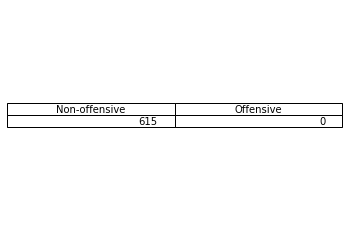

In [20]:
#printing a table of the results for the offensive and non-offensive words and their associated word count
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
df = pd.DataFrame([[not_offensive, offensive]], columns=['Non-offensive', 'Offensive'])
ax.table(cellText=df.values, colLabels=df.columns, loc='center')
plt.savefig("offensive_table", transparent=True)
plt.show()

In [21]:
correctly_spelt = tweets['misspelt'].value_counts()[0]
misspelt = tweets.shape[0] - correctly_spelt

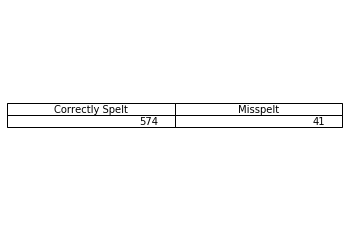

In [22]:
#printing a table of the results for the misspelt and correctly words and their associated word count
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
df = pd.DataFrame([[correctly_spelt, misspelt]], columns=['Correctly Spelt', 'Misspelt'])
ax.table(cellText=df.values, colLabels=df.columns, loc='center')
plt.savefig("misspelt_table", transparent=True)
plt.show()

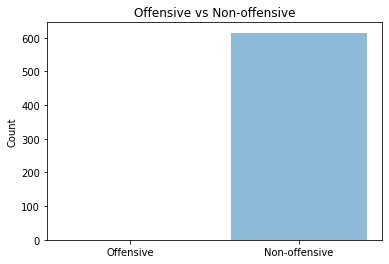

In [23]:
#visualizing results for offensive vs non-offensive words in a bar graph
x_labels = ('Offensive', 'Non-offensive')
y_pos = np.arange(len(x_labels))
performance = [offensive, not_offensive]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, x_labels)
plt.ylabel('Count')
plt.title('Offensive vs Non-offensive')
plt.savefig("offensive", transparent=True)
plt.show()

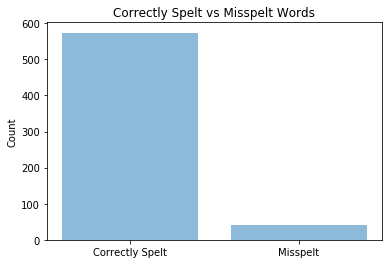

In [24]:
#visualizing results for misspelt vs correctly spelt words in a bar graph

x_labels = ('Correctly Spelt', 'Misspelt')
y_pos = np.arange(len(x_labels))
performance = [correctly_spelt, misspelt]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, x_labels)
plt.ylabel('Count')
plt.title('Correctly Spelt vs Misspelt Words')
plt.savefig("misepelt", transparent=True)
plt.show()

In [25]:
tweets

,word,offensive,misspelt
0,insanity,False,False
1,again,False,False
2,trying,False,False
3,elections,False,False
4,pm,False,False
...,...,...,...
610,covid19,False,False
611,to,False,False
612,in,False,False
613,coronavirus,False,False


In [29]:
#this function returns the correctly spelt words
def correct(df):
    result = []
    for word in df:
        result.append(spell(word))
    return result

In [30]:
misspelt_words = tweets[tweets['misspelt']==True]['word']
misspelt_words = pd.DataFrame({'misspelt word': misspelt_words})
misspelt_words['correctly spelt'] = correct(misspelt_words['misspelt word'])

In [31]:
#visualizing results for misspelt words and their correct spelling
misspelt_words

,misspelt word,correctly spelt
5,candidatert,candidate
22,mciu…,main…
41,doug,dog
42,idk,ink
55,patien…carsharing,patient…marshaling
59,dabeard,beard
71,nicolas,nicholas
88,gilat,gilt
90,transequality,transsexuality
102,coronavirusrt,coronavirus


In [32]:
#this ends the spark session or streaming session
streaming_context.stop()